# Implementación de Backprop con gráficas computacionales

El entrenamiento en redes neuronales requiere de la optimización de una función de riesgo, por lo que se hace necesario obtener las derivadas de esa función de riesgo. Para esto, se implementa el algoritmo de backpropagation que es un algoritmo de diferenciación automática, el cual permite obtener las derivadas de la función de riesgo sobre una red neuronal.

### Algortimo para aprendizaje en red neuronal

Entrenaremos nuestra red neuronal utilizando el siguiente algoritmo:

<img src="imagenes/FitFFN.png" alt="Algoritmo de aprendizaje" width="60%">

La parte central del algoritmo está en el backpropagation. Esto nos permite implementar las derivadas para poder actualizar los pesos de toda la red.

Para implementar el backpropagation utilizaremos una <b>gráfica computacional</b>.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Gráfica computacional

El algoritmo de backpropagation es parte de los métodos de diferenciación automática en modo reverse.

<img src="imagenes/ComptGraph.png" alt="Gráfica computacional" width="65%">

La idea es crear una gráfica computacional cuyo nodo de salida sea la función de riesgo, y que los nodos internos sean las capas de la red. Definidmos los diferentes nodos que utilizaremos para construir esta gráfica.

### Nodos para pre-activaciones

En primer lugar, generamos una clase que formará los nodos en la preactivación; es decir, este nodo tendrá la función de pre-activación:

$$a = Wx + b$$

Las derivadas en este caso para el modo backward serán de la forma:

$$\frac{\partial h_i^{(t)}}{\partial W_{i,j}^{(t)}} =  \frac{\partial h_i^{(t)}}{\partial a_{i}^{(t)}} x_j$$

donde $\frac{\partial h_i^{(t)}}{\partial a_{i}^{(t)}}$ es la derivada de la función de activación. El vector $x$ corresponde a la salida de la capa previa.

El esquema del nodo es como sigue:

```python
class Linear()
    def __init__(self, input_size, output_size)
        super(Linear, self).__init__()
        self.w = #Inicialización de pesos
        self.b = #Inicialización de bias
        self.d = #Guarda derivadas
    def __call__(self, x):
        # Realiza la función en forward
        ...
        return self.w@x + self.b
    
    def backward(self, layer):
        # Realiza el backward tomando la capa superior
        ...
        return #derivada de la capa
```

### Nodo para función de activación

Los nodos de las funciones de activación pueden incorporarse dentro de los nodos lineales, puesto que juntos conforman una capa. Pero también pueden computarse externamente. Siguiendo la implementación de pytorch, incorporamos estos nodos como capas aparte.

Estos nodos, en el paso forward sólo computan la función de activación $g: \mathbb{R} \to \mathbb{R}$ punto a punto en la capa de activación:

$$h = g(a)$$

La derivada que obtenemos aquí es de la forma:

$$\frac{\partial a^{t+1}}{\partial h_i^{t}}\frac{\partial h_i^{t}}{\partial a_i^{t}} = h_i' \sum_q W^{t+1}_{q,i} \frac{\partial a_q^{t+1}}{\partial h_i^{t}}$$

Ya que estamos usando la tangente hiperbólica $h_i' = 1-\tanh(a_i)^2$.

El esquema de la clase es como sigue:

```python
class Tanh():
    """Función de activación tangente hiperbólica"""
    def __init__(self):
        super(Tanh, self).__init__()
        self.act = np.tanh
        ...
    def __call__(self, x):
        return self.act(x)
    def backward(self, layer):
        ...
        return #Derivada de la capa
```

### Nodo para capa de salida

Ya que tenemos los nodos de las capas de la red, debemos definir la salida de la red. La salida puede ser de diferente índole según el problema, pero nos enfocamos aquí en un problema de clasificación, por lo que tomaremos una función Softmax.

En el paso forward, por tanto, nuestro nodo debe computar para cada neurona de salida:

$$f_y = \frac{e^{a_y}-\max_i(a_i)}{\sum_j e^{a_j-\max_i(a_i)}}$$

Recuérdese que para la $y$-ésima neurona, la derivada de la función Softmax es de la forma:

$$\frac{f_y}{a_i} = f_y(\delta_{y,i} - f_i)$$
donde:

$$\delta_{y,i} = \begin{cases} 1 & \text{ si } y=i \\ 0 & \text{ si } y \neq i \end{cases}$$

El esquema de la clase es de la siguiente forma:

```python
class Softmax():
    """Nodo para la activación Softmax"""
    def __init__(self):
        super(Softmax, self).__init__()
        self.f = None
        self.d = None
    def __call__(self, x, axis=0):
        ...
        return # Función softmax
    def backward(self, layer):
        ...
        return # Derivada de softmax
```

### Nodo de la función de riesgo

Finalmente, debemos obtener el nodo de la función de riesgo. Este es el nodo final en la gráfica computacional y, por tanto, es la función sobre la que queremos derivar. La función de riesgo depende del problema y los objetivos. Aquí usamos la entropía cruzada.

El forward será de la forma:

$$R = -\sum_i \delta_{y,i} \ln f_i$$

La derivada sobre la $y$-ésima salida para el paso backward será de la forma:

$$\frac{R}{f_y} = -\frac{1}{f_y}$$

El esquema de la clase es de la forma:

```python
class CrossEntropy():
    """Nodo para la función de riesgo"""
    def __init__(self):
        super(CrossEntropy, self).__init__()
        ...
    def __call__(self, y, pred):
        ...
        return # Riesgo en y
    def backward(self):
        ...
        return # Derivada de riesgo sobre salida f_y
```

## Aplicación a un problema concreto

Tomemos ahora un problema de clasificación y usemos la gráfica computacional para solucionarlo.

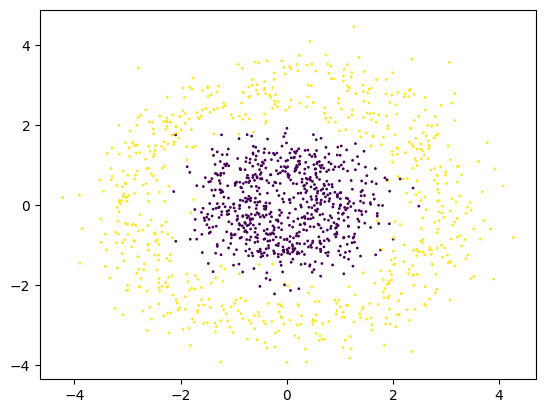

In [2]:
"""
Creación de los datos
"""
r0, r1 = 1, 3
k = 1000
X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
X = np.concatenate((X1,X2))
n,d = X.shape
Y = np.zeros(2*k)
Y[k:] += 1
noise = np.array([np.random.normal(0,1,2) for i in range(n)])
X += 0.5*noise 

#Seprara en train y en test
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

#Visualización de train set
plt.scatter(x_train[:,0], x_train[:,1],c=y_train,s=1)
plt.show()

### Creación de gráfica

La red neuronal puede verse como una gráfica computacional en que cada nodo computa una función específica. Hay una relación entre los nodos según la estructura de las capas de la red neuronal.

Definimos la clase ``Network`` que construye una red neuronal con una gráfica computacional. Para esto, usamos los nodos que hemos definido con anterioridad. En particular, definimos una red con una capa oculta, por lo que usamos:

1. Un nodo de pre-activación ``Linear(in_size, out_size)``.
2. Un nodo para función de activación ``Tanh()``
3. Un nodo más de pre-activación ``Linear(in_size, out_size)`` (no es el mismo que el anterior).
4. Un nodo para función de salida ``Softmax``.

En el método ``__call__`` definimos estructura de la gráfica; i.e., en qué orden se realizan los cómputos.

Finalmente, la gráfica computacional tiene también un paso backward el cual generamos a partir de la estructura de los nodos y aprovechando los métodos backward en cada nodo. Nótese que el backward requiere primero del cómputo de una función de riesgo y de la aplicación de backward. De cierta forma, nuestra gráfica computacional esta imcompleta, le falta el nodo último. 

Esta estructura que definimos no es única, y la forma en que hemos definido los nodos nos permite implementar redes neuronales con diferentes números de capas ocultas.

In [3]:
from node_layers import *

class Network():
    """Red neuronal como gráfica computacional"""
    def __init__(self):
        super(Network, self).__init__()
        # Nodo pre-activación
        self.l1 = Linear(2,10)
        # Nodo activación
        self.g = Tanh()
        # Nodo pre-activación
        self.l2 = Linear(10,2)
        # Nodo salida
        self.f = Softmax()
        
    def __call__(self, x):
        """Estructura la gráfica computacional"""
        # Secuencia de los cómputos
        l1 = self.l1(x)
        g = self.g(l1)
        l2 = self.l2(g)
        f = self.f(l2)
        return f
        
    def backward(self, risk_layer):
        """Aprovecha la estructura de la gráfica para computar backward"""
        self.f.backward(layer=risk_layer)
        # Derivadas de segunda capa
        dw2, db2 = self.l2.backward(layer=self.f)
        self.g.backward(layer=self.l2)
        # Derivadas de priemra capa
        dw1, db1 = self.l1.backward(layer=self.g)
        
        return dw1, dw2, db1, db2

Finalmente, la clase de la gráfica computacional se crea, esto nos permitirá computar la red neuronal. 

In [4]:
#Creación de red
ffn = Network()
#Prueba
ffn(x_train[0])

array([0.60349786, 0.39650214])

## Entrenamiento

En el entrenamiento completamos la gráfica computacional, agregando el último nodo correspondiente a la función de riesgo. De esta forma, podemos aprender los pesos de la red que resuelvan el problema. Para esto, definimos la función de descenso por gradiente. Recuérdese que el descenso por gradiente es de la forma:

$$\theta_{k,i,j} \leftarrow \theta_{k,i,j} - \eta \frac{\partial R(\theta)}{\partial W_{i,j}^{(k)}}$$
donde $\eta$ es la taza de aprendizaje. La función que definimos está determinada por la red neuronal que hemos elegido, se debe modificar para otro tipo de red.

In [5]:
def gradient_descent(net, d_net, lr=1.0):
    """Cómput del descenso por gradiente dado una red net"""
    dw1, dw2, db1, db2 = d_net
    net.l1.w -= lr*dw1
    net.l2.w -= lr*dw2
    net.l1.b -= lr*db1
    net.l2.b -= lr*db2

Ahora ya tenemos lo necesario para entrenar la red. Agregamos el nodo de la función de riesgo y aprendenmos usando las derivadas utilizados en el paso backward de nuestra gráfica computacional:

In [6]:
# Nodo de función de riesgo
risk = CrossEntropy()

#Núm épocas
epochs = 100
#Tasa de aprendizaje
lr = 0.001
total_risk = []
for t in tqdm(range(epochs)):
    epoch_risk = 0
    for x_i,y_i in zip(x_train, y_train):
        # FORWARD
        y_pred = ffn(x_i)
        risk_i = risk(int(y_i), y_pred)
        #Guradamos riesgo
        epoch_risk += risk_i
        
        # BACKWARD
        risk.backward()
        d_ffn = ffn.backward(risk_layer=risk)
        
        # Descenso por gradiente
        gradient_descent(ffn, d_ffn, lr=lr)
        
    total_risk.append(epoch_risk)

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.48it/s]


Visualizamos la función de pérdida a través de las épocas.

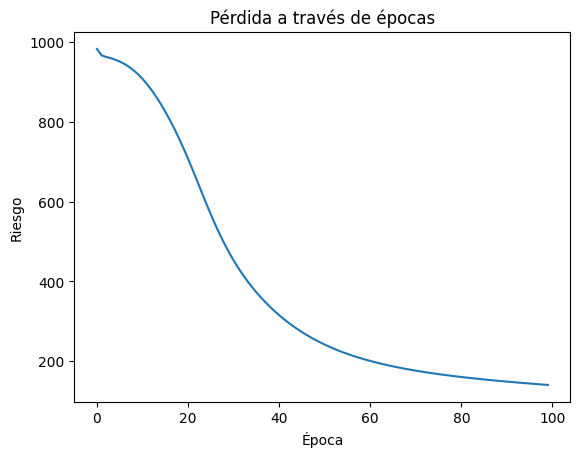

In [7]:
plt.plot(total_risk)
plt.title('Pérdida a través de épocas')
plt.xlabel('Época')
plt.ylabel('Riesgo')
plt.show()

## Evaluación y visualización del aprendizaje

Finalmente, es conveniente evaluar el desempeño del aprendizaje en nuestra red neuronal, para esto, utilizamos el dataset de evaluación. Recuérdese que la predicción de clase se hace como:

$$\hat{y} = \arg\max_y f_y$$

In [8]:
#Predicciones sobre evaluación
y_pred = [ffn(x_i).argmax() for x_i in x_test]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       297
         1.0       0.96      0.97      0.96       303

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



### Regiones de clasificación

Podemos visualizar cuáles son las regiones en que la red clasifica los datos:

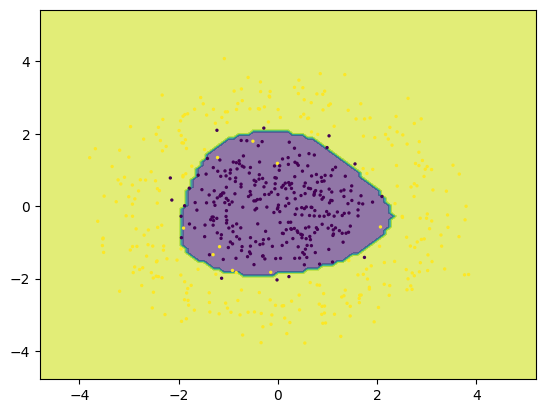

In [9]:
min1, max1 = x_test[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_train[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = np.array([ffn(x_i).argmax() for x_i in grid])
zz = yhat.reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.6)

plt.scatter(x_test[:,0], x_test[:,1],c=y_test,s=2)
plt.show()

## PyTorch

Las paqueterías de redes neuronales en python utilizan gráficas computacionales. A partir de estas, pueden entrenar de manera sencilla una red neuronal. De forma similar a lo aquí mostrado, se definen nodos.

In [10]:
import torch
import torch.nn as nn

ffn_torch = nn.Sequential(nn.Linear(2,10), nn.Tanh(), nn.Linear(10,2), nn.Softmax())

ffn_torch(torch.Tensor(x_train[0]))

/home/ia-unam/anaconda3/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.6595, 0.3405], grad_fn=<SoftmaxBackward0>)

In [11]:
# nodo de riesgo
risk_torch = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ffn_torch.parameters(), lr=0.001)

total_risk = []
for t in tqdm(range(epochs)):
    epoch_risk = 0
    for x_i, y_i in zip(x_train, torch.LongTensor(y_train)):
        # FORWARD
        y_pred = ffn_torch(torch.Tensor(x_i))
        loss = risk_torch(y_pred, y_i)
        epoch_risk += loss
        
        # BACKWARD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    total_risk.append(epoch_risk.detach())        

100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


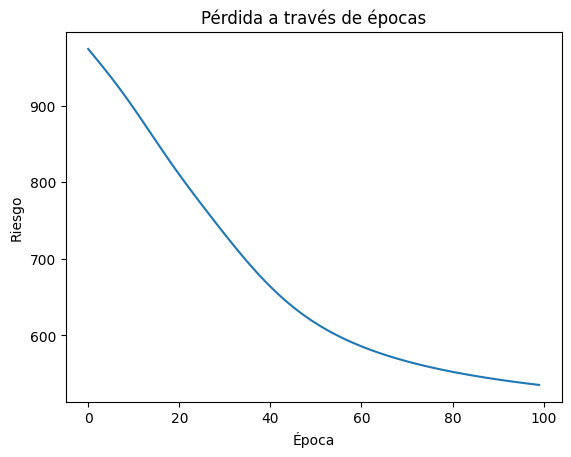

In [12]:
plt.plot(total_risk)
plt.title('Pérdida a través de épocas')
plt.xlabel('Época')
plt.ylabel('Riesgo')
plt.show()

In [13]:
y_torch = ffn_torch(torch.Tensor(x_test)).argmax(axis=1).numpy()

print(classification_report(y_torch, y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       295
           1       0.96      0.95      0.95       305

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

